# 基于 NiN 的 CIFAR-10 数据集的分类
## NiN
为了避免出现全连接层参数量过多，容易出现过拟合的情况，引入 NiN 块，用卷积代替全连接。最后使用全局池化层进行输出。
### NiN 块
内部架构：卷积层，两个 $1\times 1$ 的卷积层

### 基本架构（本质上 NiN块的不断重复）
输入：图片（$3\times 224\times 224$）

1. 
- $11\times 11$ 卷积层（96）,步幅为 4
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （96@26*26）

2.  
- $5\times 5$ 卷积层（256）,填充为 2
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （256@12*12）

3.  
- $3\times 3$ 卷积层（384）,填充为 1
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $3\times 3$ 最大汇聚层，步幅为 2 （384@5*5）

4. 
- $3\times 3$ 卷积层（10）,填充为 1
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- $1\times 1$ 卷积层
- ReLU 函数激活
- 全局平均汇聚 （10@1*1）

输出：10 个类别样本

In [1]:
# imports
import basic
from torch import nn
from torch import optim
import torch

class NiN(basic.Net):
    def __init__(self):
        super(basic.Net).__init__()
        self.NiN()

    @staticmethod
    def nin_block(in_channels, out_channels, kernel_size, strides, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size=1),
            nn.ReLU()
        )
        
    def NiN(self):
        self.net = nn.Sequential(
            self.nin_block(3,96,kernel_size=11,strides=4,padding=0),
            nn.MaxPool2d(3,stride=2),
            self.nin_block(96,256,kernel_size=5,strides=1,padding=2),
            nn.MaxPool2d(3, stride=2),
            self.nin_block(256,384,kernel_size=3,strides=1,padding=1),
            nn.MaxPool2d(3,stride=2),
            nn.Dropout(0.5),
            self.nin_block(384,10,kernel_size=3,strides=1,padding=1),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten())

Files already downloaded and verified
Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['truck', 'airplane', 'horse', 'cat']


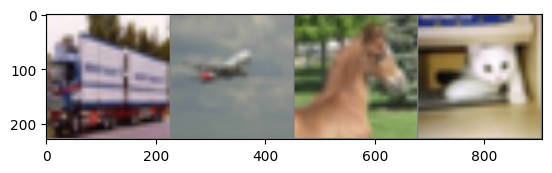

In [2]:
ROOT = "./data"
Model_PATH = "./model/NiN"
BatchSize = 128
optimizer = optim.SGD
criterion = nn.CrossEntropyLoss()

trains, tests, labels = basic.load_CIFAR10_datasets(BatchSize,224,ROOT)
basic.show_some_samples(trains,labels)

In [3]:
nin = NiN()
X = torch.rand(size=(1,3,224,224))
for layer in nin.net:
    X=layer(X)
    print(layer.__class__.__name__,"output shape:\t", X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [ ]:
nin.train(trains,criterion,optimizer,epochs=3)
torch.save(nin.net,Model_PATH)

In [ ]:
nin = NiN()
nin.try_gpu()
nin.net=torch.load(Model_PATH,map_location=nin.device)
nin.accuracy(tests)
nin.label_accuracy(tests,labels)